<a href="https://colab.research.google.com/github/argareeva/DataAnalyticsProject/blob/main/%D0%9A%D0%B0%D1%82%D0%B0%D0%BB%D0%B8%D0%B7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 6.0 MB/s eta 0:00:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Прекурсор     10 non-null     int64  
 1   Растворитель  10 non-null     int64  
 2   t, C          10 non-null     int64  
 3   t, ч          10 non-null     int64  
 4   pH            10 non-null     float64
 5   HNO3          10 non-null     int64  
 6   t1, C         3 non-null      float64
 7   H1, Дж/г      3 non-null      float64
 8   t2, C         3 non-null      float64
 9   H2, Дж/г      3 non-null      float64
 10  a(842)        10 non-null     float64
 11  D(842), нм    10 non-null     float64
 12  SBET, м2/г    7 non-null      float64
 13  Vпор, см3/г   7 non-null      float64
 14  N, нм         3 non-null      float64
 15  Lk, мкм       3 non-null      float64
 16  d1, нм        3 non-null      float64
 17  d2, нм        3 non-null      float64
 18  w1, %         3 non-null      flo

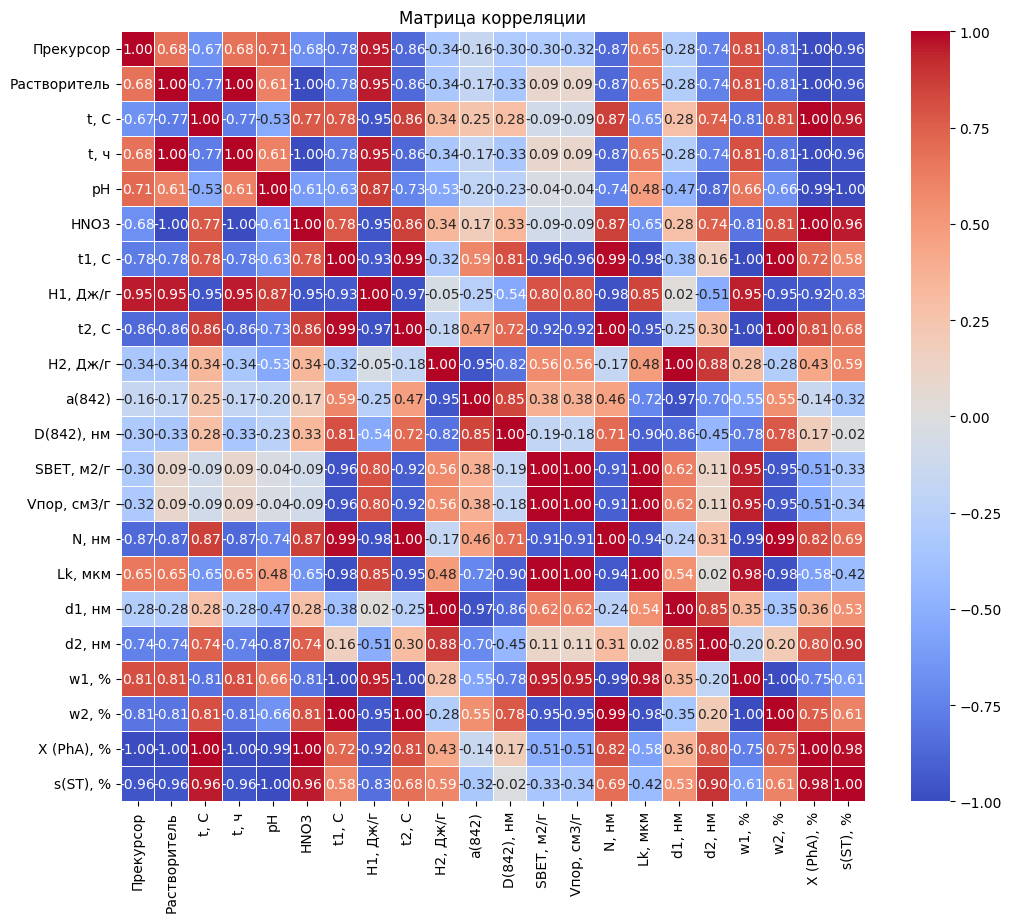

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('Book.csv', delimiter=';')

data_numeric = data.drop(columns=['#', 'Фазовый состав', 'A1(C)', 'A2(C)', 'A1(O)', 'A2(O)', 'A1(Fe)', 'A2(Fe)', 'CH3COOH',	'HCl',	'H2SO4'])

print(data_numeric.info())
print(data_numeric.describe())

correlation_matrix = data_numeric.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Матрица корреляции')
plt.show()

много коррелируемых между собой признаков

In [15]:
df_cleaned = data_numeric.dropna(subset=['X (PhA), %', 's(ST), %'])

df_cleaned.head()

,Прекурсор,Растворитель,"t, C","t, ч",pH,HNO3,"t1, C","H1, Дж/г","t2, C","H2, Дж/г",...,"SBET, м2/г","Vпор, см3/г","N, нм","Lk, мкм","d1, нм","d2, нм","w1, %","w2, %","X (PhA), %","s(ST), %"
0,11,21,150,8,1.5,31,115.4,540.8,420.2,-20.32,...,1261.0,0.708,350.0,5.0,9.7,25.9,86.06,13.94,70.21,69.70
1,12,22,24,24,6.0,0,114.7,547.4,417.8,-24.07,...,1827.4,1.001,325.0,6.0,9.1,24.0,90.28,9.72,67.76,65.31
2,12,22,24,24,5.0,0,113.5,550.3,415.3,-19.48,...,6527.1,3.311,300.0,10.0,9.9,25.3,96.49,3.51,68.00,66.57


1 вариант - делаем xgboost на 3 строках

In [6]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X = df_cleaned.drop(columns=['X (PhA), %', 's(ST), %'])
y = df_cleaned[['X (PhA), %', 's(ST), %']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgboost_model = XGBRegressor(objective='reg:squarederror', random_state=42)
xgboost_model.fit(X_train, y_train)

xgboost_y_pred = xgboost_model.predict(X_test)
xgboost_mae = mean_absolute_error(y_test, xgboost_y_pred)
xgboost_mse = mean_squared_error(y_test, xgboost_y_pred)

print(f'MAE (XGBoost): {xgboost_mae:.4}')
print(f'MSE (XGBoost): {xgboost_mse:.4}')

feature_weights = pd.DataFrame({'Feature': X.columns, 'Weight': xgboost_model.feature_importances_})
print(feature_weights)

MAE (XGBoost): 2.671
MSE (XGBoost): 7.345
         Feature  Weight
0      Прекурсор     0.0
1   Растворитель     0.0
2           t, C     0.0
3           t, ч     0.0
4             pH     1.0
5           HNO3     0.0
6          t1, C     0.0
7       H1, Дж/г     0.0
8          t2, C     0.0
9       H2, Дж/г     0.0
10        a(842)     0.0
11    D(842), нм     0.0
12    SBET, м2/г     0.0
13   Vпор, см3/г     0.0
14         N, нм     0.0
15       Lk, мкм     0.0
16        d1, нм     0.0
17        d2, нм     0.0
18         w1, %     0.0
19         w2, %     0.0


In [8]:
from sklearn.model_selection import cross_val_score
import numpy as np

cv_scores = cross_val_score(xgboost_model, X_train, y_train, cv=2, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)
print("Среднее значение RMSE на кросс-валидации:", cv_rmse_scores.mean())

Среднее значение RMSE на кросс-валидации: 0.9069735882608649


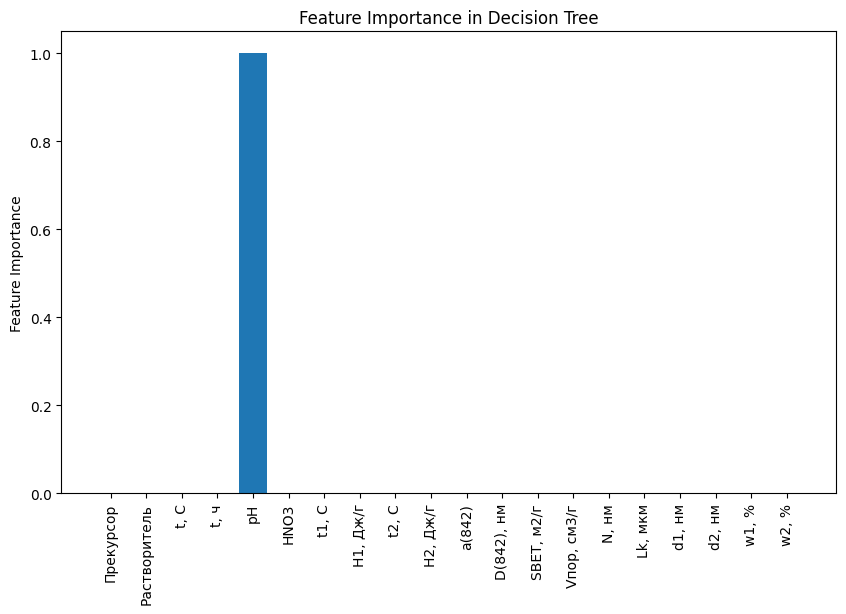

In [9]:
import matplotlib.pyplot as plt

feature_importance = xgboost_model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
plt.bar(features, feature_importance)
plt.xticks(rotation=90)
plt.ylabel('Feature Importance')
plt.title('Feature Importance in Decision Tree')

plt.show()

2 вариант - удаляем все признаки с nan-значениями и делаем decision tree на трех строках (метрики такие же, как и у xgboost), ph - единственный значимый признак

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

X = df_cleaned.drop(columns=['X (PhA), %', 's(ST), %', 'N, нм', 'Lk, мкм'])
y = df_cleaned[['X (PhA), %', 's(ST), %']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt_model = DecisionTreeRegressor()

param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_dt = GridSearchCV(dt_model, param_grid, cv=2, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_dt.fit(X_train, y_train)

print("Оптимальные параметры:", grid_search_dt.best_params_)

cv_scores = cross_val_score(grid_search_dt.best_estimator_, X_train, y_train, cv=2, scoring='neg_mean_squared_error')
print(f'Среднее значение MSE на кросс-валидации: {-cv_scores.mean():.4}')

y_pred_dt = grid_search_dt.best_estimator_.predict(X_test)

mae_dt = mean_absolute_error(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)

print(f'MAE (Decision Tree): {mae_dt:.4}')
print(f'MSE (Decision Tree): {mse_dt:.4}')

Оптимальные параметры: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Среднее значение MSE на кросс-валидации: 0.8226
MAE (Decision Tree): 3.42
MSE (Decision Tree): 12.64


In [19]:
dt_model_tuned = DecisionTreeRegressor(max_depth=3, min_samples_leaf=1, min_samples_split=2, random_state=42)
dt_model_tuned.fit(X_train, y_train)

y_pred_dt_tuned = dt_model_tuned.predict(X_test)

mae_dt_tuned = mean_absolute_error(y_test, y_pred_dt_tuned)
mse_dt_tuned = mean_squared_error(y_test, y_pred_dt_tuned)

print(f'MAE (Tuned Decision Tree): {mae_dt_tuned:.4}')
print(f'MSE (Tuned Decision Tree): {mse_dt_tuned:.4}')

feature_weights = pd.DataFrame({'Feature': X.columns, 'Weight': dt_model_tuned.feature_importances_})
print(feature_weights)

MAE (Tuned Decision Tree): 2.67
MSE (Tuned Decision Tree): 7.341
         Feature  Weight
0      Прекурсор     0.0
1   Растворитель     0.0
2           t, C     0.0
3           t, ч     0.0
4             pH     1.0
5           HNO3     0.0
6          t1, C     0.0
7       H1, Дж/г     0.0
8          t2, C     0.0
9       H2, Дж/г     0.0
10        a(842)     0.0
11    D(842), нм     0.0
12    SBET, м2/г     0.0
13   Vпор, см3/г     0.0
14        d1, нм     0.0
15        d2, нм     0.0
16         w1, %     0.0
17         w2, %     0.0


In [20]:
cv_scores = cross_val_score(dt_model_tuned, X_train, y_train, cv=2, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)
print(f'Среднее значение RMSE на кросс-валидации: {cv_rmse_scores.mean():.4}')

Среднее значение RMSE на кросс-валидации: 0.907


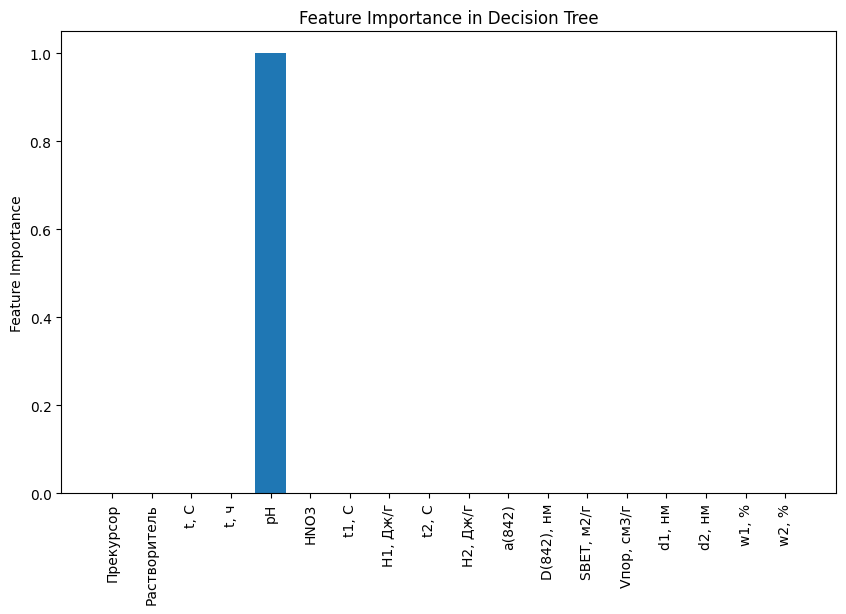

In [21]:
import matplotlib.pyplot as plt

feature_importance = dt_model_tuned.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
plt.bar(features, feature_importance)
plt.xticks(rotation=90)
plt.ylabel('Feature Importance')
plt.title('Feature Importance in Decision Tree')

plt.show()

3 вариант - линейная регрессия (метрики хуже)

In [24]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'MAE: {mae:.4}')
print(f'MSE: {mse:.4}')

feature_weights = pd.DataFrame({'Feature': X.columns, 'Weight_d1': lr_model.coef_[0],
                                'Weight_d2': lr_model.coef_[1]})
print(feature_weights)

MAE: 3.51
MSE: 13.39
         Feature     Weight_d1     Weight_d2
0      Прекурсор  6.776264e-21  0.000000e+00
1   Растворитель  0.000000e+00  0.000000e+00
2           t, C  0.000000e+00  0.000000e+00
3           t, ч  0.000000e+00  0.000000e+00
4             pH -1.086584e-08 -5.704564e-08
5           HNO3  0.000000e+00  0.000000e+00
6          t1, C -1.303900e-08 -6.845477e-08
7       H1, Дж/г  3.151093e-08  1.654324e-07
8          t2, C -2.716459e-08 -1.426141e-07
9       H2, Дж/г  4.987419e-08  2.618395e-07
10        a(842) -6.628161e-09 -3.479784e-08
11    D(842), нм -1.792863e-07 -9.412531e-07
12    SBET, м2/г  5.106617e-05  2.680974e-04
13   Vпор, см3/г  2.510008e-08  1.317754e-07
14        d1, нм  8.692670e-09  4.563652e-08
15        d2, нм  1.412559e-08  7.415934e-08
16         w1, %  6.747685e-08  3.542535e-07
17         w2, % -6.747685e-08 -3.542535e-07


In [25]:
cv_scores = cross_val_score(lr_model, X_train, y_train, cv=2, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)
print(f'Среднее значение RMSE на кросс-валидации: {cv_rmse_scores.mean():.4}')

Среднее значение RMSE на кросс-валидации: 0.907


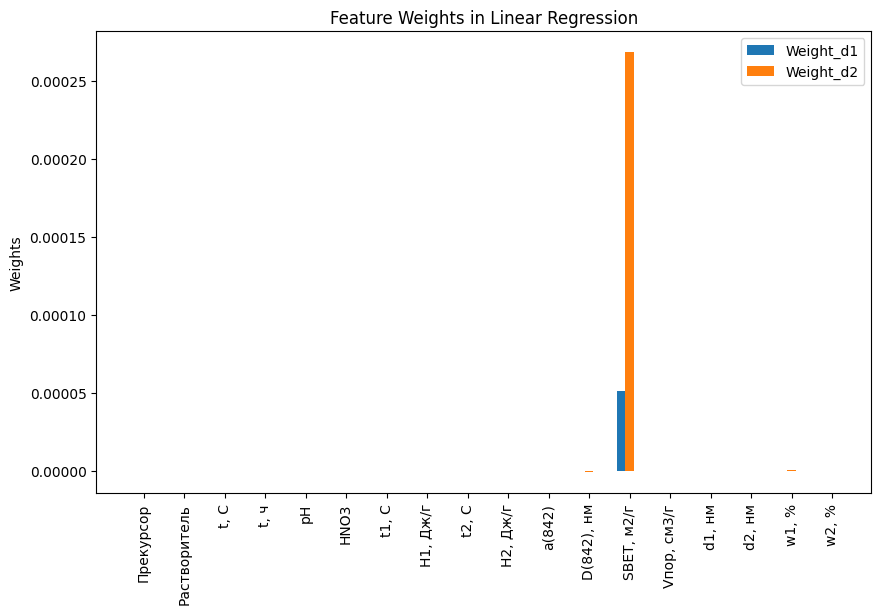

In [23]:
weights_d1 = lr_model.coef_[0]
weights_d2 = lr_model.coef_[1]

features = X.columns
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2

r1 = np.arange(len(features))
r2 = [x + bar_width for x in r1]

ax.bar(r1, weights_d1, width=bar_width, label='Weight_d1')
ax.bar(r2, weights_d2, width=bar_width, label='Weight_d2')

ax.set_xticks([r + bar_width for r in range(len(features))])
ax.set_xticklabels(features, rotation=90)
ax.set_ylabel('Weights')
ax.set_title('Feature Weights in Linear Regression')
ax.legend()

plt.show()